集成算法的目的是将几个基估计器的预测与给定的学习算法结合起来，以提高单个估计器的通用性和鲁棒性。

集成方法一般分为两种：

- 在平均法（averaging methods)中，该方法的原理是构建多个独立的估计器，然后`取预测结果的平均`。一般来说，组合之后的估计器是会比单个估计器要好，因为`方差减小`了。

   - 示例: Bagging methods, Forests of randomized trees, …

- 相反，在提升法(boosting methods)中，`基估计器是按顺序建立的，降低了偏差`。其动机是将几个弱模型结合起来，形成一个强大的整体。

    - 示例: AdaBoost, Gradient Tree Boosting, …

## Bagging

在集成算法中， bagging方法形成了一类算法，它在原始训练集的随机子集上建立几个黑箱估计器的实例，然后将它们的个体预测聚合起来，形成最终的预测。

这些方法通过在基本估计器(例如决策树)的构造过程中`引入随机化`，然后`将其集成起来`，从而`降低单个基本估计器(如决策树)的方差`。

在许多情况下，bagging方法是一个非常简单的方法可以用来改进相对单一模型，而不需要调整底层。由于bagging方法提供了一种减少过度拟合的途径，因此**对强大模型和复杂模型(例如，充分生长的决策树)最有效**，与之对比的提升法在弱模型(例如浅层决策树)上表现最好。

![20220712152323](https://cdn.jsdelivr.net/gh/xihuishawpy/PicBad@main/blogs/pictures/20220712152323.png)

In [1]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

bagging = BaggingClassifier(KNeighborsClassifier(),
                            max_samples=0.5, max_features=0.5)

### 随机森林 -- RandomForestClassifier

在随机森林中(RandomForestClassifier和RandomForestRegressor类)， 集成模型中的每棵树构建时的样本都是由`训练集经过有放回抽样`(比如a bootstrap sample自助式采样法)得来。

在构建树的过程中进行结点分割时，选择的分割点是所有特征的最佳分割点，或特征的大小为 max_features 的随机子集的最佳分割。

这两种随机的目的是`降低森林估计器的方差`。事实上，单个决策树通常表现出很高的方差，并且往往会过拟合。在森林中注入随机性产生的决策树具有一定的解耦预测误差(decoupled prediction errors)。通过取这些预测的平均值，可以抵消掉一些误差。

`随机森林通过组合不同的树来减少方差，有时以增加一点点偏差为代价`。在实践中，方差减少通常是值得关注的，因此产生了一个整体更好的模型。

**scikit-learn实现通过平均它们的概率预测来组合分类器，而不是让每个分类器为单个类别进行投票。**

In [2]:
import numpy as np
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_boston,load_iris

li = load_iris()
features2 = li.feature_names
x_cls ,y_cls = li.data,li.target
x_cls = pd.DataFrame(x_cls,columns=features2)
y_cls = pd.DataFrame(y_cls,columns=['target'])

from sklearn.model_selection import train_test_split
X_cls_train,X_cls_test,y_cls_train,y_cls_test = train_test_split(x_cls,y_cls,random_state=2022,test_size=0.2)

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 默认bootstrap=True,有放回抽样，使用部分数据集
rf_cls = RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=3,max_samples=0.8,bootstrap=True,random_state=2022)
rf_cls.fit(X_cls_train,y_cls_train)
rf_cls.score(X_cls_train,y_cls_train)

print(accuracy_score(y_cls_test,rf_cls.predict(X_cls_test)))
rf_cls.predict_proba(X_cls_test[:5])

0.9666666666666667


array([[0.        , 0.01675679, 0.98324321],
       [0.        , 0.01264354, 0.98735646],
       [1.        , 0.        , 0.        ],
       [0.        , 0.02520051, 0.97479949],
       [1.        , 0.        , 0.        ]])

注意：

控制树大小的参数的默认值(例如max_depth, min_samples_leaf等)会导致完全生长和未修剪的树，在某些数据集上可能树会非常大。为了减少内存消耗，应通过设置这些参数值来`控制树的复杂性和大小`。

在每次分割时，特性总是随机地进行分配。因此，即使训练数据相同，max_features=n_features, bootstrap=False，在搜索最佳分割的过程中，如果枚举的几个分割对准则的改进相同，那么找到的最佳分割也会有所不同。为了在拟合过程中获得确定性行为，必须确定random_state。

### 极端随机树 -- ExtraTreesClassifier

在极端随机树(参见 ExtraTreesClassifier 和 ExtraTreesRegressor 类)中，`计算分割点的方法随机性进一步增强`。

与随机森林中一样，使用了候选特征的随机子集，但不像随机森林中是寻找最具区分度的阈值，而是`对每个候选特征随机绘制阈值，并选择这些随机生成的阈值中最佳的作为分割规则`。这种做法通常能够减少一点模型的方差，代价则是略微地增大偏差

In [4]:
from sklearn.ensemble import ExtraTreesClassifier

# 默认bootstrap = False，用整个数据集。
# 毕竟极端随机树，特征分裂阈值是随机生成的，随机性毕竟大了，所以没必要样本随机取了。
ef_cls = ExtraTreesClassifier(n_estimators=100,criterion='gini',max_depth=3,bootstrap=False,random_state=2022)
ef_cls.fit(X_cls_train,y_cls_train)
ef_cls.score(X_cls_train,y_cls_train)

print(accuracy_score(y_cls_test,ef_cls.predict(X_cls_test)))
ef_cls.predict_proba(X_cls_test[:5])

0.9666666666666667


array([[0.0052545 , 0.24071436, 0.75403113],
       [0.        , 0.10228781, 0.89771219],
       [0.93719823, 0.05370412, 0.00909765],
       [0.01406477, 0.33230632, 0.65362891],
       [0.95267728, 0.03891332, 0.0084094 ]])

### 参数

使用这些方法时要调整的参数主要是 n_estimators 和 max_features。

**n_estimators**是森林里树的数量，通常数量越大，效果越好，但是计算时间也会随之增加。此外要注意，当树的数量超过一个临界值之后，算法的效果并不会很显著地变好。

**max_features**是分割节点时考虑的特征的随机子集的大小。`这个值越低，方差减小得越多，但是偏差的增大也越多`。根据经验:

- **回归问题**使用 `max_features = None` （考虑所有特征）；max_depth = None 和 min_samples_split = 2结合通常会有不错的效果（即完全生长的树）；
- **分类问题**使用 `max_features = 'sqrt'` （随机考虑 sqrt(n_features) 特征）是比较好的默认值；

以上这些（默认）值通常不是最佳的，同时还可能消耗大量的内存，最佳参数值应由`交叉验证`获得。 


另外，在随机森林中，默认使用自助采样法（bootstrap = True）， 然而 extra-trees 的默认策略是使用整个数据集（bootstrap = False）。 当使用自助采样法方法抽样时，泛化精度是可以通过剩余的或者袋外(out-of-bag) 的样本来评估的，设置 oob_score = True 即可实现。


注意：默认参数下模型复杂度是：O(M*N*log(N)) ， 其中 M 是树的数目， N 是样本数。 可以通过设置以下参数来`降低模型复杂度`： 
- `min_samples_split`（分割内部节点的最小样本数） ；
- `max_leaf_nodes`（最大叶子节点的数量） ；
- `max_depth`（最大深度）  ；
- `min_samples_leaf`（一个叶子节点所需的最小样本数）；

## 特征重要性评估

特征对目标变量预测的相对重要性可通过`特征使用的相对顺序（即深度）`进行评估。在scikit-learn中，一个特征所贡献的`样本比例`与`拆分后的不纯度的减少`相结合，形成了对该特征预测能力的标准化估计。

通过对几个随机树的预测能力估计值进行平均，可减少估计值的方差，并将其用于特征选择。这就是平均减少不纯度（MDI）。

`基于不存度减少`计算的特征重要性有2个缺陷，
1. 不纯度是根据训练集计算出来的，不一定在测试集上也是一样效果；
2. 有利于高基数特征（高基数特征high cardinality features，也就是通常是数值特征，不纯度减少得更多）；

基于树的模型提供一种`基于平均不纯度下降（MDI）`的特征重要性的替代测量。不纯度是通过决策树的分割标准（`Gini`、`Log Loss`或`Mean Squared Error`）来量化的。然而，`当模型过拟合时，这种方法会给那些可能对未见过的数据、没有预测作用的特征以很高的重要性。`所以，如果RF过拟合了，其特征重要性中，即便是对目标变量没有预测作用的特征，其重要性也会很高！！！

另一方面，基于交换的特征重要性避免了这个问题，因为它可以在未见过的数据上进行计算。一般用`Permutation Importance`（排列重要性）替代。

- https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance
- https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance

Permutation Importance对于非线性或不可解释的估计器比较有用 ，基于排序的特征重要性定义为：**单个特征取值被随机打乱时模型得分的降低程度**。此过程破坏了特征与目标之间的关系，因此`模型得分的下降程度代表了模型对特征的依赖程度`。这种技术的好处在于它不依赖于模型，并且可以通过特征的不同排列进行多次计算。

![20220713095408](https://cdn.jsdelivr.net/gh/xihuishawpy/PicBad@main/blogs/pictures/20220713095408.png)

对于一个坏的模型来说，被认为是低重要性的特征（交叉验证得分低），对于一个好的模型来说可能是非常重要的。因此，在计算重要性之前，使用验证集来评估一个模型的预测能力总是很重要的。`排序重要性并不反映一个特征本身的内在预测价值，而是反映这个特征对一个特定模型的重要程度`。(先保证模型的cv分数靠谱，再去看特征重要性才比较有意义~~)


In [12]:
from sklearn.inspection import permutation_importance

# 一般先训练好模型，在验证集上进行 permutation_importance 计算比较合理
# n_repeats: 对某一特征进行排列组合的次数。
r = permutation_importance(rf_cls,X_cls_test,y_cls_test,n_repeats=30,random_state=2022)
r.importances_mean

array([0.02888889, 0.00222222, 0.13444444, 0.40777778])

排序重要性可以在训练集上计算，也可以在测试或验证集上计算。`使用测试集可以突出哪些特征对被检测模型的概括能力贡献最大`。在训练集上很重要但在测试集上不重要的特征可能会导致模型过拟合

In [40]:
# 多指标分析 , 对于不同的指标，即使重要性值的尺度有很大的不同，特征的排名也大致相同(但需要注意的是，样本不均衡的情况下，选取合适的指标)
scoring = ['neg_log_loss','f1_macro']

r2 = permutation_importance(rf_cls,X_cls_test,y_cls_test,n_repeats=30,random_state=2022,scoring=scoring)

for score in r2:
    r = r2[score]
    print(score,r.importances_mean)

neg_log_loss [0.03836316 0.00373886 0.4869624  0.51269595]
f1_macro [0.02762382 0.00212491 0.1320098  0.40930415]


当两个特征相关联并且其中一个特征被随机重排时，模型仍然可以通过其相关特征来访问此特征。这将导致两个特征的重要性指标降低，而这两个特征实际上可能很重要。

处理此问题的一种方法是`将关联的特征聚类，并且对于每个聚类仅保留一个特征`

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

## 完全随机树嵌入 -- RandomTreesEmbedding

RandomTreesEmbedding 实现了一个`无监督数据转换`。 

通过由完全随机树构成的森林，`RandomTreesEmbedding 使用数据最终归属的叶子节点的索引值对数据进行编码`。 该索引以 one-of-K 方式编码，最终形成一个高维的稀疏二值化编码。 这种编码可以被非常高效地计算出来，并且可以作为其他学习任务的基础。 

`编码的大小`和`稀疏度`可以通过`选择树的数量和每棵树的最大深度来确定`。对于集成中的每棵树的，每个样本对应其中的一个叶节点。 编码的大小（维度）最多为 n_estimators * 2 ** max_depth ，即森林中的叶子节点的最大数。

由于相邻数据点更可能位于一颗树的同一叶子中，该变换可以作为一种隐式地非参数密度估计。


In [44]:
from sklearn.ensemble import RandomTreesEmbedding

X = [[0,0], [1,0], [0,1], [-1,0], [0,-1]]

# 5颗树构成的森林，且每颗树最大深度为1 
random_trees = RandomTreesEmbedding(n_estimators=5, random_state=0, max_depth=1).fit(X)

# 对于X中的每个数据点x和森林中的每个树，返回x最后所在叶子的索引
print(random_trees.apply(X))

# 转换数据：其实就是对叶子索引进行one-hot encode
X_sparse_embedding = random_trees.transform(X)
X_sparse_embedding.toarray()

[[2 1 1 2 1]
 [2 1 1 2 1]
 [2 2 2 2 2]
 [1 1 1 1 1]
 [2 1 1 2 1]]


array([[0., 1., 1., 0., 1., 0., 0., 1., 1., 0.],
       [0., 1., 1., 0., 1., 0., 0., 1., 1., 0.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 1., 0., 1., 0., 0., 1., 1., 0.]])

先apply拿到leaf indices，再transform得到一个one-hot encode：

![20220713132058](https://cdn.jsdelivr.net/gh/xihuishawpy/PicBad@main/blogs/pictures/20220713132058.png)

## Boost -- AdaBoost

AdaBoost的核心原理：

在反复修改的数据版本上拟合一连串的弱学习者（即只比随机猜测稍好的模型，如小型决策树），然后通过加权多数票将所有模型的预测结果结合起来，产生最终的预测结果。

对于每个提升迭代中的数据修改，最初样本权重都被设置为wi=1/N，因此第一步只是在原始数据上训练一个弱学习器。对于每个连续迭代，样本的权重被单独修改，学习算法被重新应用于重新加权的数据。（`预测错误的样本有更高的权重`，以便下一轮学习的时候，模型更关注这些没学好的样本）

在一个给定的步骤中，在上一个步骤中被提升模型错误预测的训练例子的权重被增加，而那些被正确预测的例子的权重被降低。随着迭代的进行，难以预测的例子受到越来越大的影响。因此，`每一个后续的弱学习者都专注于序列中被前面的学习器遗漏的例子，并且学习器的预测误差越小，最后学习器的权重越高`。

In [68]:
from sklearn.ensemble import AdaBoostClassifier

# lr : 在每个提升迭代中应用于每个分类器的权重。
# 较高的lr会增加每个分类器的贡献。在lr和n_estimators参数之间有一个权衡,n_estimators越大，lr相应的也要调大
ab_cls = AdaBoostClassifier(n_estimators=1000,learning_rate=0.5,random_state=2022,algorithm='SAMME')
ab_cls.fit(X_cls_train,y_cls_train)
print(ab_cls.score(X_cls_train,y_cls_train))

print(accuracy_score(y_cls_test,ab_cls.predict(X_cls_test)))

1.0
0.9


## 梯度提升树 -- Gradient Tree Boosting

向前分阶段的方式建立了一个`加法模型`；它允许对任意可分的损失函数进行优化。

在每个阶段，`回归树被拟合在损失函数的负梯度上`，例如二元或多类对数损失。

**GradientBoostingClassifier只适合小样本数据**，当`样本数量大于数万个`样本时，`基于直方图的估计器-HistGradientBoostingRegressor`可以比GradientBoostingClassifier快几个数量级，内置了`对缺失值的支持`，从而避免了对imputer的需求。


1.0
0.9666666666666667


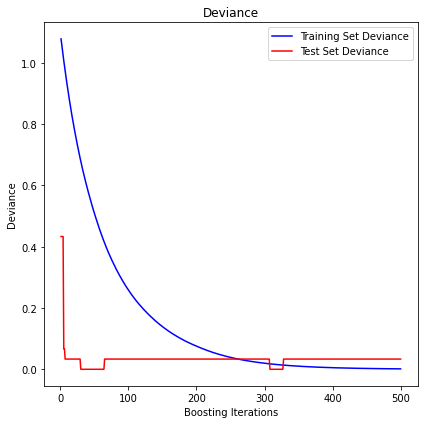

In [130]:
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01}

gbdt_cls = GradientBoostingClassifier(**params)
gbdt_cls.fit(X_cls_train,y_cls_train)
print(gbdt_cls.score(X_cls_train,y_cls_train))

print(accuracy_score(y_cls_test,gbdt_cls.predict(X_cls_test)))

# 计算测试集偏差
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(gbdt_cls.staged_predict(X_cls_test)):
    test_score[i] = 1-accuracy_score(y_cls_test, y_pred) 


fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, gbdt_cls.train_score_, 'b-',
         label='Training Set Deviance') # 直接拿到训练集偏差
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-', 
         label='Test Set Deviance') 
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

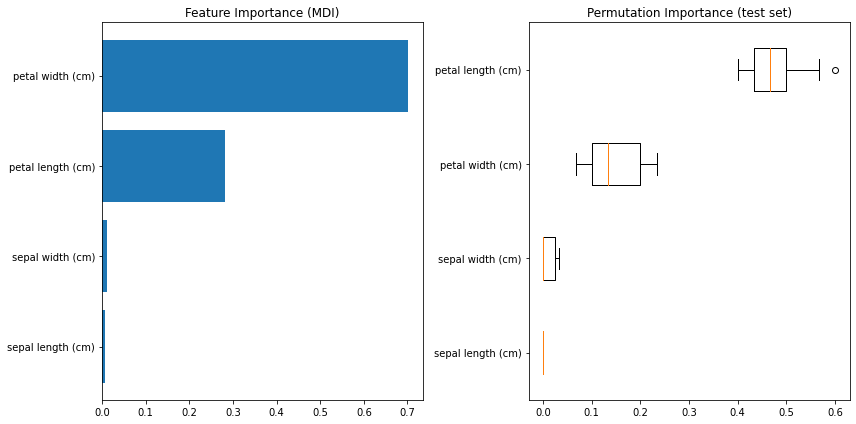

In [134]:
# 特征重要性

# 基于不纯度特征重要性
feature_importance = gbdt_cls.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_cls_train.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

# 基于 permutation_importance 排序特征重要性
result = permutation_importance(gbdt_cls, X_cls_test, y_cls_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_cls_train.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [83]:
# 基于直方图改进的GBDT,适合数据量较大的数据集
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.datasets import make_hastie_10_2

X, y = make_hastie_10_2(random_state=0)
X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

# max_iter 就是迭代次数，和gbdt里的n_estimators一样
clf = HistGradientBoostingClassifier(max_iter=100).fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
0.8965


损失函数选择：

- 回归损失有‘least_squares’, ‘least_absolute_deviation’(对异常值不太敏感)和 ‘poisson’(非常适合模型计数和频率)。
- 分类方面，‘binary_crossentropy’ 用于二分类， ‘categorical_crossentropy’用于多分类。默认情况下，损失函数是 ‘auto’


如果样本数大于10,000，则默认启用早停。早期停止行为通过 `early-stopping`, validation_fraction, n_iter_no_change, `tol`参数来控制.

处理缺失值：

- 在训练过程中，生长的树根据潜在的增益，在每次分割时无论样本是否含有缺失值都应该被划分到右边或左边。因此，在预测时，有缺失值的样本也会被分配给左或右的子节点。

- 当缺失模式具有预测性时，可以根据特征值是否缺失进行分割；如果在训练期间给定特征下没有碰见缺失值，则会将有缺少值的样本映射到具有最多样本的那个子节点上

较小的learning_rate值要求较多的弱学习器以保持一个恒定的训练误差。经验证据表明，`较小的learning_rate有利于更好的测试误差`。建议`将学习速率设置为一个小常数(例如，learning_rate <= 0.1)，并通过早期的停止选择n_estimators`。

降低偏差：

![20220713174748](https://cdn.jsdelivr.net/gh/xihuishawpy/PicBad@main/blogs/pictures/20220713174748.png)

- 指定收缩率比没有收缩拥有更好的表现。
- 将子采样和收缩率相结合能进一步的提高模型的准确率。
- 相反，使用子采样而不使用收缩的结果十分糟糕。

结论：指定学习率比没指定效果好；如果对样本子采样，就需要指定学习率。

降低方差：是对分类器中类似随机分裂的`特征进行二次采样`，通过`max_features`参数可以控制子采样特征的数量。

## 特征重要性

`单个决策树`本质上通过选择合适的分割点来进行特征选择，这些信息可以用来度量每个特征的重要性。基本想法：`一个特征在树的分割点中使用的频率越高，该特征就越重要`。这种重要性的概念可以扩展到决策树群，只需`对每棵树的基于不纯度的特征重要性进行平均`即可。